# Сlothing classification

In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
import tensorflow as tf
from tensorflow import keras

In [28]:
# !git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

## Загрузка изображений

In [29]:
from tensorflow.keras.preprocessing.image import load_img

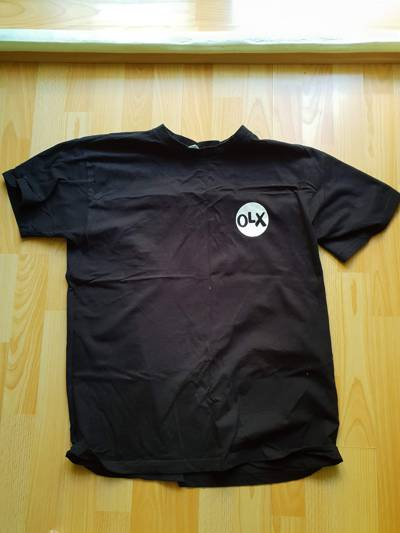

In [30]:
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = path + '/' + name
load_img(fullname)

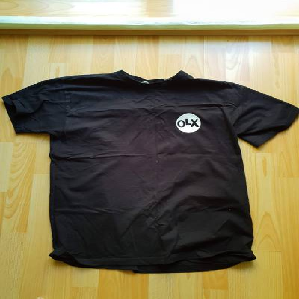

In [31]:
# Чтобы изменить размер, необходимо указать target_size

load_img(fullname, target_size=(299, 299))

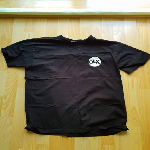

In [32]:
load_img(fullname, target_size=(150, 150))

## Использование предварительно-обученной модели:

There are a list of available models:

https://keras.io/api/applications/

https://www.tensorflow.org/api_docs/python/tf/keras/applications

В данном листе буду использовать модель Xception:

In [33]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

- Xception - сама модель
- preprocess_input - функция для подготовки изображения к использованию моделью
- decode_prediction - функция для декодирования предсказания модели


Перед загрузкой модели необходимо вручную скачать веса модели Xception из-за ошибки доступа

In [34]:
model = Xception(
    weights='imagenet',
    input_shape=(299, 299, 3)
)

Переходим к тестированию модели...

In [35]:
# Сперва загружаем изображение с помощью ф-ции load_img
img = load_img(fullname, target_size=(299, 299))

In [36]:
# Переменная img - это объект Image, который нужно преобразовать в массив NumPy
x = np.array(img)

# Этот массив должен получить ту же форму, что и изображение. Проверим:
x.shape

(299, 299, 3)

Все соответствует форме вывода, которую мы указали при загрузке. Однако модель не ожидает только одного изображения, она получает пакет (несколько).
 Наш массив должен иметь 4 измерения:
 - кол-во изобр
 - ширину
 - высоту
 - количество каналов

In [37]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

Перед тем, как применить модель к прогнозам, необходимо подготовить ее с помощью функции preprocess_input. Эта функция преобразует целые числа от 0 до 255 в исходном массиве в числа от -1 до 1

In [38]:
X = preprocess_input(X)

In [39]:
# Делаем прогноз

pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


In [40]:
# Взглянем на этот массив

pred.shape

(1, 1000)

In [41]:
pred[0, :10]

array([0.00032371, 0.00015738, 0.00021349, 0.00015237, 0.00024763,
       0.00030504, 0.00032059, 0.0001475 , 0.00020362, 0.00014927],
      dtype=float32)

In [42]:
# Ф-ция предсказывает 5 наиболее вероятных классов для этого изображения
decode_predictions(pred)

[[('n03595614', 'jersey', np.float32(0.68196255)),
  ('n02916936', 'bulletproof_vest', np.float32(0.038140047)),
  ('n04370456', 'sweatshirt', np.float32(0.034324896)),
  ('n03710637', 'maillot', np.float32(0.011354239)),
  ('n04525038', 'velvet', np.float32(0.0018453641))]]

Не совсем тот результат, которого мы ожидали. Скорее всего, изображения, подобные этой футболке не распространены в ImageNet. Поэтому результат бесполезен.

Мы можем использовать эту нейросеть в качестве базовой модели для решения своей задачи

## Обучение с переносом опыта (Transfer_Learning)

In [43]:
# Вместо всего набора данных изображения загружаются в память небольшими пакетами
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [44]:
# Для экономии времени воспользуемся более мелким форматом
image_size = (150, 150)
batch_size = 32

In [45]:
# Производим предобработку для train множества:

# Применяем ф-цию preprocess_input к каждому изобр
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input) 

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [46]:
# Производим предобработку для val множества:

validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


Сперва нам нужно загрузить базовую модель - предварительно обученную модель, которую используем для извлечения векторного представления из изображений:

In [47]:
# Инициализация  базовой модели с include_top=False
base_model = Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

# Заморозим веса модели
base_model.trainable = False

Теперь построим модель классификации одежды:

In [48]:
inputs = keras.Input(shape=(150, 150, 3)) # Входные изображения должны быть размером 150х150 с 3 каналами

base = base_model(inputs, training=False) # Использование base_model для извлечения высокоуровненых признаков
vector = keras.layers.GlobalAveragePooling2D()(base) # Извлекает векторное представление: приобразуует выходные данные base_model в вектор
outputs = keras.layers.Dense(10)(vector) # Добавляет плотный слой размером 10: по одному элементу для каждого класса

model = keras.Model(inputs, outputs) # Объединяет входные и выходные данные в модель Keras

Была создана модель, которая умеет принимать изображение, получать векторное представление, используя базовую модель, и делать окончательный прогноз с помощью плотного слоя

## Обучение модели

In [49]:
# Сперва задаем параметры

learning_rate = 0.01 # скорость обучения

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate), # оптимизатор, который регулирует веса сети
    loss=keras.losses.CategoricalCrossentropy(from_logits=True), # Обучение классификации с несколькими классами
    metrics=["accuracy"], 
)

In [50]:
# Тренируем 10 эпох:

history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 569ms/step - accuracy: 0.5735 - loss: 1.6481 - val_accuracy: 0.7595 - val_loss: 0.8415
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 468ms/step - accuracy: 0.8267 - loss: 0.5200 - val_accuracy: 0.7801 - val_loss: 1.0540
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 476ms/step - accuracy: 0.8667 - loss: 0.3866 - val_accuracy: 0.8123 - val_loss: 0.7561
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 441ms/step - accuracy: 0.9300 - loss: 0.1995 - val_accuracy: 0.7977 - val_loss: 0.8550
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 438ms/step - accuracy: 0.9433 - loss: 0.1617 - val_accuracy: 0.8182 - val_loss: 0.7634
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 439ms/step - accuracy: 0.9809 - loss: 0.0687 - val_accuracy: 0.8065 - val_loss: 0.8661
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 441ms/step - accuracy: 0.9617 - loss: 0.1099 - val_accuracy: 0.8035 - val_loss: 0.9462
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 441ms/step - accuracy: 0.9783 - loss: 0.0687 - val_accu

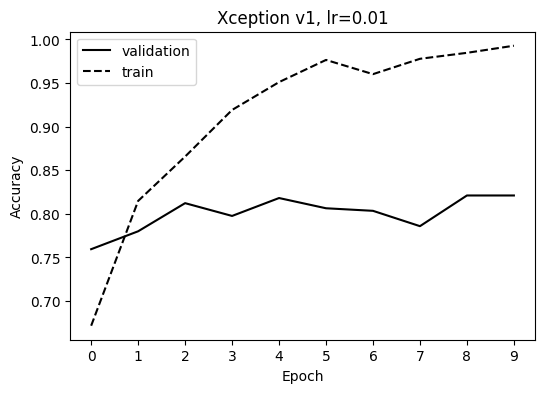

In [51]:
plt.figure(figsize=(6, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(10))

plt.legend()


# plt.savefig('xception_v1_0_01.svg')

plt.show()

Для валидационного множества уровень accuracy остается равным приблизительно 80%

### Настройка скорости обучения:

In [52]:
# Переписываем функцию для создания модели:

def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vector)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

Пробуем обучить при learning_rate = 0.001

In [53]:
model = make_model(learning_rate=0.001)
history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 469ms/step - accuracy: 0.4900 - loss: 1.4988 - val_accuracy: 0.7918 - val_loss: 0.7051
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 468ms/step - accuracy: 0.7766 - loss: 0.6352 - val_accuracy: 0.7918 - val_loss: 0.6397
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.8300 - loss: 0.4960 - val_accuracy: 0.8152 - val_loss: 0.5746
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 446ms/step - accuracy: 0.8737 - loss: 0.4006 - val_accuracy: 0.8152 - val_loss: 0.5503
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 453ms/step - accuracy: 0.8941 - loss: 0.3575 - val_accuracy: 0.8152 - val_loss: 0.5402
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 446ms/step - accuracy: 0.9015 - loss: 0.3388 - val_accuracy: 0.8270 - val_loss: 0.5286
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 452ms/step - accuracy: 0.9320 - loss: 0.2743 - val_accuracy: 0.8211 - val_loss: 0.5446
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - accuracy: 0.9399 - loss: 0.2469 - val_accu

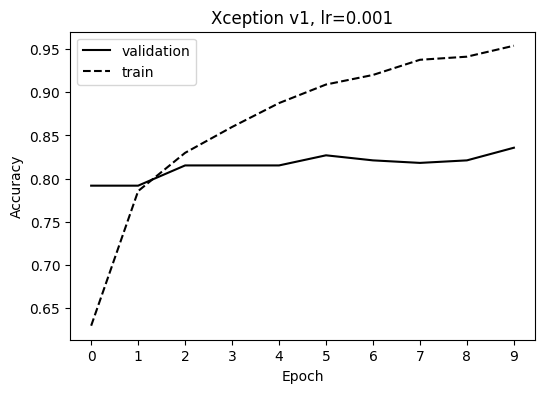

In [54]:
# Отрисовываем: 

plt.figure(figsize=(6, 4))

epochs = history_0_001.epoch
val = history_0_001.history['val_accuracy']
train = history_0_001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


# plt.savefig('xception_v1_0_001.svg')

plt.show()

Пробуем обучить при learning_rate = 0.0001

In [55]:
model = make_model(learning_rate=0.0001)
history_0_0001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 452ms/step - accuracy: 0.1844 - loss: 2.2926 - val_accuracy: 0.4164 - val_loss: 1.6852
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 452ms/step - accuracy: 0.5096 - loss: 1.5146 - val_accuracy: 0.6041 - val_loss: 1.2955
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 529ms/step - accuracy: 0.6137 - loss: 1.2104 - val_accuracy: 0.6569 - val_loss: 1.0967
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 458ms/step - accuracy: 0.6704 - loss: 1.0335 - val_accuracy: 0.6891 - val_loss: 0.9771
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 444ms/step - accuracy: 0.7058 - loss: 0.9315 - val_accuracy: 0.7185 - val_loss: 0.9015
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 444ms/step - accuracy: 0.7118 - loss: 0.8661 - val_accuracy: 0.7214 - val_loss: 0.8466
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 450ms/step - accuracy: 0.7286 - loss: 0.8139 - val_accuracy: 0.7390 - val_loss: 0.8005
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 453ms/step - accuracy: 0.7656 - loss: 0.7577 - val_accu

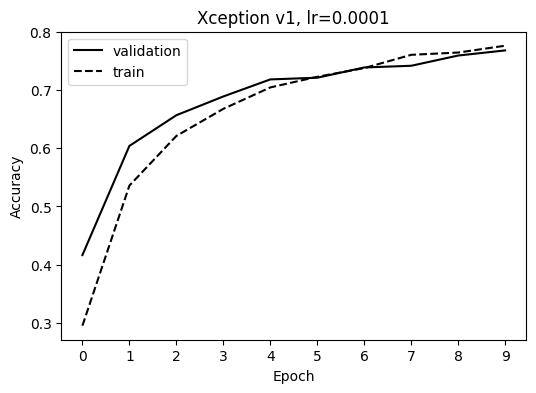

In [56]:
plt.figure(figsize=(6, 4))

epochs = history_0_0001.epoch
val = history_0_0001.history['val_accuracy']
train = history_0_0001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.0001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


# plt.savefig('xception_v1_0_0001.svg')

plt.show()

Объединяем результаты:

In [57]:
epochs = np.arange(10)
val_0_01 = history.history['val_accuracy']
val_0_001 = history_0_001.history['val_accuracy']
val_0_0001 = history_0_0001.history['val_accuracy']

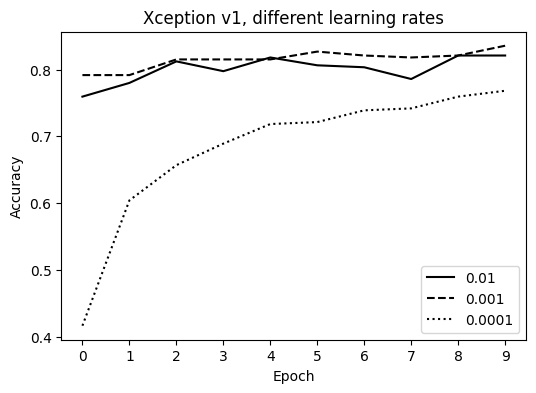

In [58]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val_0_01, color='black', linestyle='solid', label='0.01')
plt.plot(epochs, val_0_001, color='black', linestyle='dashed', label='0.001')
plt.plot(epochs, val_0_0001, color='black', linestyle='dotted', label='0.0001')


plt.title('Xception v1, different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

# plt.savefig('xception_v1_all_lr.svg')

plt.show()

Разница между 0.01 и 0.001 несущественна

### Сохранение модели:

Как только модель обучена, мы можем сохранить ее, используя метод save_weights:

In [59]:
# model.save_weights(
#     'xception_v1_model.h5', # Выходной файл
#     save_format='h5' # Его формат
# )

Для того, чтобы сохранить лучшую модель, мы можем использовать метод callback и специальный класс ModelCheckpoint. 

ModelCheckpoint отслеживает наилучшую достоверность и сохраняет результаты на диск каждый раз, когда она повышается. 


In [60]:
model = make_model(learning_rate=0.001)

In [61]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0_001 = model.fit(
    train_ds, 
    epochs=10,
    validation_data=val_ds, 
    callbacks=callbacks  # Определяет список обратных вызовов, которые будут использоваться во время обучения
)


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 489ms/step - accuracy: 0.5076 - loss: 1.4273 - val_accuracy: 0.7683 - val_loss: 0.7321
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 613ms/step - accuracy: 0.7858 - loss: 0.6286 - val_accuracy: 0.7742 - val_loss: 0.6739
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - accuracy: 0.8355 - loss: 0.4938 - val_accuracy: 0.8006 - val_loss: 0.6065
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 488ms/step - accuracy: 0.8678 - loss: 0.4272 - val_accuracy: 0.8035 - val_loss: 0.5704
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 498ms/step - accuracy: 0.8970 - loss: 0.3599 - val_accuracy: 0.8094 - val_loss: 0.5649
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - accuracy: 0.9116 - loss: 0.3273 - val_accuracy: 0.8152 - val_loss: 0.5473
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 450ms/step - accuracy: 0.9255 - loss: 0.2837 - val_accuracy: 0.8211 - val_loss: 0.5441
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - accuracy: 0.9325 - loss: 0.2615 - val_accu

Поскольку обратный вызов ModelCheckpoint сохраняет модель, только когда она улучшается, у нас получилось 4 файла с нашей моделью вместо десяти

### Добавление дополнительных слоев

Ранее мы обучили модель с одним плотных слоем:
 - outputs = keras.layers.Dense(10)(vector)

Теперь попробуем добавить еще один плотный слой между векторным представлением и выводом

In [62]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)  # добавляет еще один слой размером 100
    drop = keras.layers.Dropout(droprate)(inner) # Слой с отсевом и настраиваемой частотой 

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

Попробуем обучить модель с 4 разными частотами droprate:
- 0.0 - ничего не замораживается
- 0.2 - замораживается 20% слоя
- 0.5 - замораживается половина
- 0.8 - замораживается 80% слоя

In [63]:
model = make_model(learning_rate=0.001, droprate=0.0)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_0_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0 = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=val_ds, 
    callbacks=callbacks
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 523ms/step - accuracy: 0.5632 - loss: 1.3131 - val_accuracy: 0.8035 - val_loss: 0.6323
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 443ms/step - accuracy: 0.8175 - loss: 0.5368 - val_accuracy: 0.8094 - val_loss: 0.5460
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 441ms/step - accuracy: 0.8912 - loss: 0.3529 - val_accuracy: 0.8240 - val_loss: 0.5665
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 445ms/step - accuracy: 0.9200 - loss: 0.2691 - val_accuracy: 0.8065 - val_loss: 0.5710
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 527ms/step - accuracy: 0.9581 - loss: 0.1729 - val_accuracy: 0.8211 - val_loss: 0.5408
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 511ms/step - accuracy: 0.9769 - loss: 0.1260 - val_accuracy: 0.8270 - val_loss: 0.5700
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 479ms/step - accuracy: 0.9846 - loss: 0.0959 - val_accuracy: 0.8152 - val_loss: 0.5634
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 462ms/step - accuracy: 0.9948 - loss: 0.0650 - val_accu

In [64]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_2_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_1 = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=val_ds, 
    callbacks=callbacks
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 467ms/step - accuracy: 0.5385 - loss: 1.3705 - val_accuracy: 0.7947 - val_loss: 0.6761
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.7781 - loss: 0.6163 - val_accuracy: 0.7889 - val_loss: 0.6077
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 445ms/step - accuracy: 0.8382 - loss: 0.4857 - val_accuracy: 0.7889 - val_loss: 0.6057
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 445ms/step - accuracy: 0.8788 - loss: 0.3632 - val_accuracy: 0.7977 - val_loss: 0.5348
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 447ms/step - accuracy: 0.9134 - loss: 0.2886 - val_accuracy: 0.8182 - val_loss: 0.5499
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 449ms/step - accuracy: 0.9300 - loss: 0.2132 - val_accuracy: 0.7889 - val_loss: 0.5443
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 451ms/step - accuracy: 0.9472 - loss: 0.1765 - val_accuracy: 0.8240 - val_loss: 0.5498
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 451ms/step - accuracy: 0.9587 - loss: 0.1363 - val_accu

In [65]:
model = make_model(learning_rate=0.001, droprate=0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_5_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_2 = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=val_ds, 
    callbacks=callbacks
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 462ms/step - accuracy: 0.4913 - loss: 1.5363 - val_accuracy: 0.7654 - val_loss: 0.7661
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 493ms/step - accuracy: 0.7116 - loss: 0.8318 - val_accuracy: 0.7654 - val_loss: 0.6954
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - accuracy: 0.7602 - loss: 0.6883 - val_accuracy: 0.8123 - val_loss: 0.5978
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 441ms/step - accuracy: 0.8172 - loss: 0.5719 - val_accuracy: 0.8123 - val_loss: 0.5675
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 442ms/step - accuracy: 0.8057 - loss: 0.5264 - val_accuracy: 0.8094 - val_loss: 0.5726
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 559ms/step - accuracy: 0.8306 - loss: 0.4634 - val_accuracy: 0.8035 - val_loss: 0.5546
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 481ms/step - accuracy: 0.8533 - loss: 0.4261 - val_accuracy: 0.8240 - val_loss: 0.5324
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 614ms/step - accuracy: 0.8830 - loss: 0.3482 - val_accu

In [66]:
model = make_model(learning_rate=0.001, droprate=0.8)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_8_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_3 = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=val_ds, 
    callbacks=callbacks
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 508ms/step - accuracy: 0.3167 - loss: 2.1213 - val_accuracy: 0.6422 - val_loss: 1.1550
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 52s 538ms/step - accuracy: 0.5101 - loss: 1.3969 - val_accuracy: 0.7449 - val_loss: 0.9039
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 581ms/step - accuracy: 0.5517 - loss: 1.2921 - val_accuracy: 0.7654 - val_loss: 0.8537
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 615ms/step - accuracy: 0.6015 - loss: 1.1204 - val_accuracy: 0.7537 - val_loss: 0.7765
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 498ms/step - accuracy: 0.6063 - loss: 1.1177 - val_accuracy: 0.7419 - val_loss: 0.7716
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 462ms/step - accuracy: 0.6259 - loss: 1.0752 - val_accuracy: 0.7830 - val_loss: 0.7152
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 535ms/step - accuracy: 0.6210 - loss: 0.9780 - val_accuracy: 0.8035 - val_loss: 0.6938
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - accuracy: 0.6452 - loss: 0.9851 - val_accu

In [70]:
# сохраняем результаты

epochs = history_0.epoch

train00 = history_0.history['accuracy']
train02 = history_1.history['accuracy']
train05 = history_2.history['accuracy']
train08 = history_3.history['accuracy']

val00 = history_0.history['val_accuracy']
val02 = history_1.history['val_accuracy']
val05 = history_2.history['val_accuracy']
val08 = history_3.history['val_accuracy']

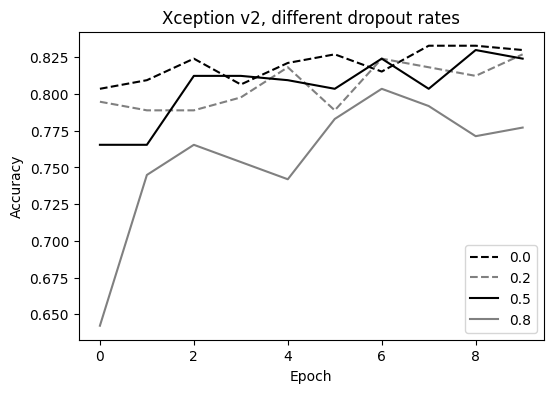

In [71]:
# отрисовываем

plt.figure(figsize=(6, 4))

plt.plot(epochs, val00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, val02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, val08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout.svg')

plt.show()

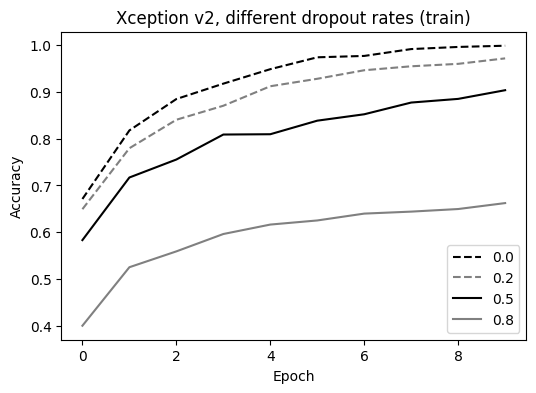

In [72]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, train00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, train02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, train08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates (train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout_train.svg')

plt.show()

Наилучший уровень отсева = 0.0

## Расширение данных (Data augmentation)

Для улучшения качества нашей модели, мы можем увеличить количество данных.

В данном примере мы сгенерируем данные из уже существующих.

Например:
- отразить изображение по вертикали и горизонтали
- повернуть изображение
- немного увеличить или уменьшить масштаб
- изменить изображение другими шумами

Keras предоставляет встроенный способ расширения набора данных. Он основан на ImageDataGenerator. У него множество аргументов, которые отвечают за приращение набора данных

Более детальное изучение представлено в файле 07-augmentations

In [73]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


In [74]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [75]:
model = make_model(learning_rate=0.001, droprate=0.0)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=val_ds, 
    callbacks=callbacks
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.5615 - loss: 1.3412

/Users/oudzhi/PycharmProjects/ML_BookCamp/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 474ms/step - accuracy: 0.5625 - loss: 1.3380 - val_accuracy: 0.7801 - val_loss: 0.7018
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 466ms/step - accuracy: 0.7865 - loss: 0.6395 - val_accuracy: 0.7683 - val_loss: 0.7051
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - accuracy: 0.8220 - loss: 0.5166 - val_accuracy: 0.8035 - val_loss: 0.5965
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 447ms/step - accuracy: 0.8626 - loss: 0.4010 - val_accuracy: 0.7889 - val_loss: 0.7103
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 448ms/step - accuracy: 0.8742 - loss: 0.3900 - val_accuracy: 0.8240 - val_loss: 0.5876
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 446ms/step - accuracy: 0.8780 - loss: 0.3299 - val_accuracy: 0.8182 - val_loss: 0.5567
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 445ms/step - accuracy: 0.9024 - loss: 0.2928 - val_accuracy: 0.8065 - val_loss: 0.6121
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 446ms/step - accuracy: 0.9211 - loss: 0.2370 - val_accuracy: 0.818

In [76]:
epochs = history.epoch
accuracy = history.history['val_accuracy']

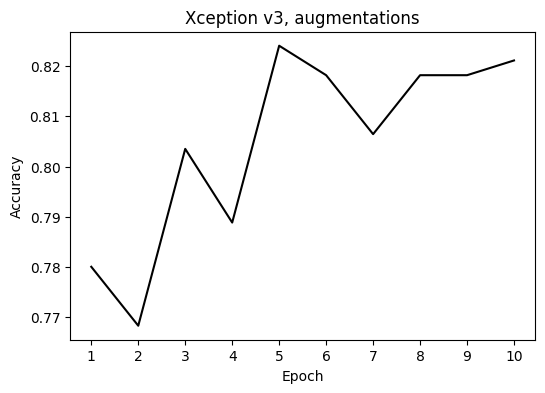

In [79]:
# Сдвигаем нумерацию эпох
epochs = [epoch + 1 for epoch in epochs]

plt.figure(figsize=(6, 4))

plt.plot(epochs, accuracy, color='black', linestyle='solid')

# Устанавливаем шаг тиков
plt.xticks(epochs)

plt.title('Xception v3, augmentations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig('xception_v3_aug.svg')

plt.show()

На 5 эпохе достигается оптимальный результат

## Дополняем модель

In [80]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(299, 299, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile( # конфигурирует модель, делая её готовой к обучению с заданными параметрами оптимизации и оценки производительности.
        optimizer=keras.optimizers.Adam(learning_rate), # Оптимизатор
        loss=keras.losses.CategoricalCrossentropy(from_logits=True), # Функция потерь
        metrics=["accuracy"], # Метрики
    )
    
    return model

In [81]:
image_size = (299, 299)
batch_size = 32

In [82]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [83]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


In [84]:
# Обучаем финальную модель:

model = make_model(learning_rate=0.001, droprate=0.0)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v4_large_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_l = model.fit(
    train_ds, 
    epochs=10,
    validation_data=val_ds, 
    callbacks=callbacks
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.6326 - loss: 1.1062 - val_accuracy: 0.8446 - val_loss: 0.4791
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8544 - loss: 0.4290 - val_accuracy: 0.8651 - val_loss: 0.3956
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.8972 - loss: 0.3200 - val_accuracy: 0.8651 - val_loss: 0.3951
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9023 - loss: 0.2771 - val_accuracy: 0.8827 - val_loss: 0.3657
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.9152 - loss: 0.2436 - val_accuracy: 0.8768 - val_loss: 0.3737
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9373 - loss: 0.2051 - val_accuracy: 0.8856 - val_loss: 0.3679
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.9269 - loss: 0.2174 - val_accuracy: 0.8710 - val_loss: 0.3655
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9345 - loss: 0.1880 - val_accuracy: 0.8827 - v

Лучшая модель - xception_v4_large_06_0.886.keras (обучена на большом наборе данных)
Вторая лучшая модель - xception_v2_0_0_08_0.833keras (обучена на базовом наборе данных с отсевом 0.0)

Дальнейшее тестирование модели будет в файле chapter-07-clothing-test